# Quaternary plotting sandbox

Testing quaternary plotting class/functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

<IPython.core.display.Javascript object>


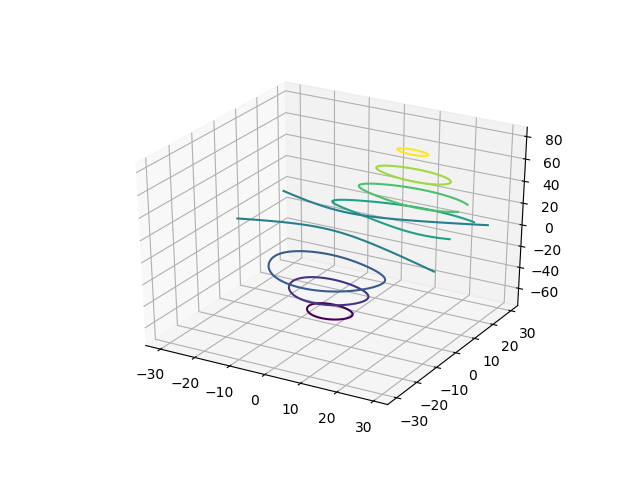

In [2]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
X,Y,Z = axes3d.get_test_data(0.05)
cset = ax.contour(X,Y,Z, cmap=cm.viridis)


In [135]:
def get_vertex_pairs(vertices):
    "get all unique pairs of vertices"
    pairs = []
    for i, v1 in enumerate(vertices):
        for j, v2 in enumerate(vertices):
            if j > i:
                pairs.append(v1)
                pairs.append(v2)
    pairs = np.asarray(pairs)
    return pairs

def plot_outline(vertices,ax=None,**kwargs):
    "plot lines between all vertices"
    dim = vertices.shape[1]
    pairs = get_vertex_pairs(vertices)
    if ax==None:
        fig = plt.figure()
        if dim==2:
            ax = fig.add_subplot(111)
            p = ax.plot(pairs[:,0],pairs[:,1],**kwargs)
        if dim==3:
            ax = fig.add_subplot(111,projection='3d')
            p = ax.plot(xs=pairs[:,0],ys=pairs[:,1],zs=pairs[:,2],**kwargs)
    else:
        if dim==2:
            p = ax.plot(pairs[:,0],pairs[:,1],**kwargs)
        if dim==3:
            p = ax.plot(xs=pairs[:,0],ys=pairs[:,1],zs=pairs[:,2],**kwargs)
    return p

# def make_quat_axes(ax=None,**kwargs):
#     if ax==None:
#         fig = plt.figure()
#         ax = fig.add_subplot(111,projection='3d')
#     vertices = np.array([[0,0,0],[1,0,0],[1/2,3**0.5/2,0],[1/2,3**0.5/6,6**0.5/3]])
#     plot_outline(vertices,ax=ax,**kwargs)
#     return ax
 

def fractions_to_quaternary(points,normalize=True):
    """
    Convert atomic fractions to quaternary coordinates (3D hexagonal Miller indices)
    
    Args:
    -----
    points: list or array of atomic fractions
    normalize: if True, normalize all atomic fractions to sum to 1
    """
    if type(points) == list:
        points = np.array(points)
    
    if normalize==True:
        #normalize all points to 1 (independent of scale since cartesian space is not scaled)
        ptsum = np.sum(points,axis=1)
        points = points/ptsum[:,None]

    xa = points[:,0]
    xb = points[:,1]
    xc = points[:,2]
    xd = points[:,3]
    u = 2*xa + xb + xd - 1
    v = 2*xb + xa + xd - 1
    w = xd
    
    return np.column_stack((u,v,w))

def quaternary_to_cartesian(points):
    """
    Convert quaternary coordinates to Cartesian coordinates
    
    Args:
    -----
    points: array of quaternary coordinates
    """
    u = points[:,0]
    v = points[:,1]
    w = points[:,2]
    origin = (1/2,3**0.5/6,0)
    dx = -u/2 + v/2 
    dy = -(3**0.5/6)*u - (3**0.5/6)*v 
    dz = (6**0.5/3)*w
    x = origin[0] + dx
    y = origin[1] + dy
    z = origin[2] + dz
    return np.column_stack((x,y,z))

def fractions_to_cartesian(points,normalize=True):
    """
    Convert atomic fractions directly to Cartesian coordinates
    First coordinate corresponds to left corner, second to right, third to back, fourth to top
    
    Args:
    -----
    points: list or array of atomic fractions
    normalize: if True, normalize all atomic fractions to sum to 1
    """
    qp = fractions_to_quaternary(points,normalize=normalize)
    cp = quaternary_to_cartesian(qp)
    return cp
    
class QuaternaryAxes:
    def __init__(self,scale=1,ax=None):
        self.scale = scale
        self.ax = ax
        self.corner_labels = {}
        self.corner_num = {'l':0,'r':1,'b':2,'t':3}
#         self.vertices = np.array([[0,0],[1/2,3**0.5/2],[1,0]])#*self.scale
#         self.corner_coords=dict(zip(['left','top','right'], list(self.vertices)))
    
    def draw_axes(self,**kwargs):
        """
        draw quaternary axes
        
        Args:
        -----
        kwargs: kwargs to pass to plt.plot
        """
        if self.ax==None:
            fig = plt.figure()
            self.ax = fig.add_subplot(111,projection='3d')
            
        vertices = np.array([[0,0,0],[1,0,0],[1/2,3**0.5/2,0],[1/2,3**0.5/6,6**0.5/3]])
        plot_outline(vertices,ax=self.ax,**kwargs)

    
    def plot(self,points,normalize=True,**kwargs):
        """
        quaternary analog of plt.plot 
        
        Args:
        -----
        points: list or array of atomic fractions
        normalize: if True, normalize all atomic fractions to sum to 1
        kwargs: kwargs to pass to plt.plot
        """
        cp = fractions_to_cartesian(points,normalize=normalize)
        x = cp[:,0]
        y = cp[:,1]
        z = cp[:,2]
        p = self.ax.plot(x,y,z,**kwargs)
        return p
    
    def add_colorbar(self, **kwargs):
        """
        add a colorbar to the figure
        
        Args:
        -----
        kwargs: kwargs to pass to plotting.add_colorbar
        """
        add_colorbar(ax=self.ax,**kwargs)
    
    def scatter(self,points, normalize=True, colorbar=False, cb_kwargs={}, **scatter_kw):
        """
        quaternary analog of plt.scatter
        
        Args:
        -----
        points: list or array of atomic fractions
        normalize: if True, normalize all atomic fractions to sum to 1
        colorbar: if True, add a colorbar
        cb_kwargs: kwargs to pass to add_colorbar
        scatter_kw: kwargs to pass to plt.scatter
        """
        cp = fractions_to_cartesian(points,normalize=normalize)
        x = cp[:,0]
        y = cp[:,1]
        z = cp[:,2]
        p = self.ax.scatter(x,y,z,**kwargs)
        
        if colorbar==True:
            #get vmin and vmax
            try:
                cb_kwargs['vmin']
            except KeyError:
                cb_kwargs['vmin'] = np.min(c)
            try:
                cb_kwargs['vmax']
            except KeyError:
                cb_kwargs['vmax'] = np.max(c)
            self.add_colorbar(**cb_kwargs)
        
        return p
    
    def axis_points(self,corner1,corner2,multiple):
        """
        return a set of points lying on the axis between corner1 and corner2
        
        Args:
        -----
        corner1: first corner (l,r,b,t)
        corner2: second corner (l,r,b,t)
        multiple: spacing between points
        """
        x1 = np.arange(multiple,self.scale,multiple) #ascending order
        x2 = self.scale - x1 #descending order
        zeros = np.zeros(len(x1))
        idx1 = self.corner_num[corner1]
        idx2 = self.corner_num[corner2]
        pts = np.zeros((len(x1),4))
        pts[:,idx1] = x1
        pts[:,idx2] = x2
        
        return pts
    
    def corner_axis_ticks(self,corner,tick_format='.1f',multiple=0.2,offset=0.05,shrink=0.6,color='k',**plt_kwargs):
        """
        add axis tick marks for multiple corners
        
        Args:
        -----
        corners: corner for which ticks will be added (l,r,b,t)
        tick_format: format string for tick labels
        multiple: spacing between ticks
        offset: offset between axis and tick label
        shrink: distance between end of tick and tick label (fraction of offset)
        plt_kwargs: kwargs to pass to plt.plot for drawing tick lines
        """
        
        if corner not in ('l','r','b','t'):
            try:
                corner = self.corner_labels[corner]
                if corner not in ('l','r','b','t'):
                    raise Exception('Lookup on corner resulted in unexpected key: {}'.format(corner))
            except KeyError:
                raise Exception('{} not found in corner_labels'.format(corner))
        
        x1 = np.arange(multiple,self.scale,multiple) #ascending order
        x2 = self.scale - x1 #descending order
        zeros = np.zeros(len(x1))
        if corner=='l': #xa - ticks between C and A, keep xb=xd=0
            pts = np.column_stack((x1,zeros,x2,zeros))
        elif corner=='r': #xb - ticks between A and B, keep xc=xd=0
            pts = np.column_stack((x2,x1,zeros,zeros))
        elif corner=='b': #xc - ticks between B anc C, keep xa=xd=0
            pts = np.column_stack((zeros,x2,x1,zeros))
        elif corner=='t': #xd - ticks between A and D, keep xb=xc=0
            pts = np.column_stack((x2,zeros,zeros,x1))
        
        ps = np.sum(pts,axis=0)
        nonzero_idx = list(np.where(ps!=0)[0])
        zero_idx = list(np.where(ps==0)[0])
        
        txt_pts = np.copy(pts)
        dash_end = np.copy(pts)
        
        #offset labels
        txt_pts[:,nonzero_idx] = txt_pts[:,nonzero_idx] + offset
        dash_end[:,nonzero_idx] = dash_end[:,nonzero_idx] + offset*(1-shrink)
        txt_pts[:,zero_idx] = txt_pts[:,zero_idx] - offset
        dash_end[:,zero_idx] = dash_end[:,zero_idx] - offset*(1-shrink)
        
        labels = x1
        for p,tp,de, l in zip(pts,txt_pts,dash_end,labels):
            cp = fractions_to_cartesian([p])[0]
            cpt = fractions_to_cartesian([tp])[0]
            cde = fractions_to_cartesian([de])[0]
            self.ax.text(x=cpt[0],y=cpt[1],z=cpt[2],
                         s=('{:>{fmt}}'.format(l,fmt=tick_format)),ha='center',va='center')
                            #xy=cp, xytext=cpt)#, arrowprops=dict(facecolor='black',arrowstyle='-'))
            #print(p,tp)
            #print(np.stack((p,de)))
            self.plot(np.stack((p,de)),color=color,**plt_kwargs) #plot dashes
            
    def axes_ticks(self, corners='lrbt', tick_format='.1f',multiple=0.2,offset=0.05,shrink=0.6,color='k',**plt_kwargs):
        """
        add axis tick marks for multiple corners
        
        Args:
        -----
        corners: string of corners for which ticks will be added
        tick_format: format string for tick labels
        multiple: spacing between ticks
        offset: offset between axis and tick label
        shrink: distance between end of tick and tick label (fraction of offset)
        plt_kwargs: kwargs to pass to plt.plot for drawing tick lines
        """
        for corner in corners:
            self.corner_axis_ticks(corner, tick_format=tick_format,multiple=multiple,offset=offset,shrink=shrink,color=color,**plt_kwargs)
            
    def _get_gridline_pairs(self,pts1,pts2):
        """
        get pairs of points for drawing gridlines
        
        Args:
        -----
        pts1: first set of axis points
        pts2: second set of axis points
        """
        nonzero_idx1 = np.where(np.sum(pts1,axis=0)!=0)
        nonzero_idx2 = np.where(np.sum(pts2,axis=0)!=0)
        common_idx = np.intersect1d(nonzero_idx1, nonzero_idx2)
        pts1_srt = pts1[np.argsort(pts1[:,common_idx],axis=None),:]
        pts2_srt = pts2[np.argsort(pts2[:,common_idx],axis=None),:]

        gridline_pairs = []
        for p1, p2 in zip(pts1_srt,pts2_srt):
            gridline_pairs.append(np.vstack((p1,p2)))
            
        return gridline_pairs
    
    def face_gridlines(self,face,multiple=0.2,ls='--',lw=0.5,color='gray',**kwargs):
        """
        plot gridlines for a single face of the tetrahedron
        
        Args:
        -----
        face: front, left, right, or bottom (f, l, r, b)
        multiple: spacing between gridlines
        kwargs: kwargs to pass to plt.plot
        """
        corner_dict = {'f':'lrt','l':'lbt','r':'rbt','b':'lrb'}
        corners = corner_dict[face]
        
        pts1 = self.axis_points(corners[0],corners[1],multiple)
        pts2 = self.axis_points(corners[0],corners[2],multiple)
        pts3 = self.axis_points(corners[1],corners[2],multiple)
        
        gridline_pairs = self._get_gridline_pairs(pts1,pts2)  \
                        + self._get_gridline_pairs(pts1,pts3) \
                        + self._get_gridline_pairs(pts2,pts3)
        
        for gp in gridline_pairs:
            self.plot(gp,ls=ls,lw=lw,color=color,**kwargs)
            
    def gridlines(self,faces='flrb',multiple=0.2,ls='--',lw=0.5,color='gray',**kwargs):
        """
        plot gridlines for multiple faces
        
        Args:
        -----
        faces: string of faces on which to draw gridlines. defaults to all (flrb)
        multiple: spacing between gridlines
        kwargs: kwargs to pass to plt.plot
        """
        for face in faces:
            self.face_gridlines(face,multiple,ls=ls,lw=lw,color=color,**kwargs)
        
        
    def label_corner(self,corner,label,offset=0.05,**kwargs):
        """
        Label a single corner of the triange.
        
        corner:    corner to label (left, right, back, or top)
        label:  label text
        offset: distance from corner in fractional coordinates. Default 0.05
        kwargs: kwargs to pass to pyploy annotate
        """
        if corner in ['left','l']:
            frac = np.array([[1+offset,-offset/3,-offset/3,-offset/3]])
        elif corner in ['right','r']:
            frac = np.array([[-offset/3,1+offset,-offset/3,-offset/3]])
        elif corner in ['back','b']:
            frac = np.array([[-offset/3,-offset/3,1+offset,-offset/3]])
        elif corner in ['top','t']:
            frac = np.array([[-offset/3,-offset/3,-offset/3,1+offset]])
        else:
            raise Exception('Invalid corner argument: {}. Choose left, right, back, or top (or short name l, r, b, or t)'.format(corner))
        x,y,z = fractions_to_cartesian(frac,normalize=False)[0]
        self.ax.text(x,y,z,s=label,**kwargs)
        #update axis_labels dict
        self.corner_labels[label] = corner
    
    def label_corners(self,labels,offset=0.05,order='lrbt',**kwargs):
        """
        Label all corners of the triangle.
        
        labels: list of label strings
        offset: distance from corner in fractional coordinates. Default 0.05
        order: order in which labels are given. Default is lrbt (left, right, back, top)
        kwargs: kwargs to pass to pyplot text
        """
        #corner_dict = {'l':'left','r':'right','b':'back','t':'top'}
        for i, s in enumerate(labels):
            corner = order[i]
            #corner = corner_dict[c]
            self.label_corner(corner,s,offset=offset,**kwargs)
    
    def draw_normslice(self,slice_axis,slice_start,**kwargs):
        """
        draw a ternary slice normal to one of the quaternary axes
        
        Args:
        -----
        slice_axis: axis normal to the slice (l,r,b,t or user-defined corner label)
        slice_start: value of slice_axis at which to draw the slice
        kwargs: kwargs to pass to plt.plot_trisurf
        """
        if slice_axis not in ('l','r','b','t'):
            try:
                slice_axis = self.corner_labels[slice_axis]
            except KeyError:
                raise Exception('{} not found in corner_labels'.format(slice_axis))
        corner_num = self.corner_num[slice_axis]
        
        #create array of points to define plane (in fractional coords)
        plane_pts = np.zeros([4,4])
        plane_pts[:,corner_num] = slice_start
        for r in range(len(plane_pts)):
            plane_pts[r,r] = 1 - slice_start
        plane_pts = np.delete(plane_pts,corner_num,axis=0)
        
        #convert to cartesian
        cpts = fractions_to_cartesian(plane_pts)
        x = cpts[:,0]
        y = cpts[:,1]
        z = cpts[:,2]
        
        #print(plane_pts)
        self.ax.plot_trisurf(x,y,z,**kwargs)
        
    def expand_axeslims(self,factor):
        """
        expand x, y, and z axes limits by factor
        Useful for making space for corner labels if offset is large
        
        Args:
        -----
        factor: factor by which to expand all axes lims
        """
        xlim = self.ax.get_xlim()
        xrng = max(xlim) - min(xlim)
        xoffset = xrng*(factor-1)/2
        self.ax.set_xlim([xlim[0]-xoffset,xlim[1]+xoffset])

        ylim = self.ax.get_ylim()
        yrng = max(ylim) - min(ylim)
        yoffset = yrng*(factor-1)/2
        self.ax.set_ylim([ylim[0]-yoffset,ylim[1]+yoffset])

        zlim = self.ax.get_zlim()
        zrng = max(zlim) - min(zlim)
        zoffset = zrng*(factor-1)/2
        self.ax.set_zlim([zlim[0]-zoffset,zlim[1]+zoffset])
        
        
            
        

<IPython.core.display.Javascript object>


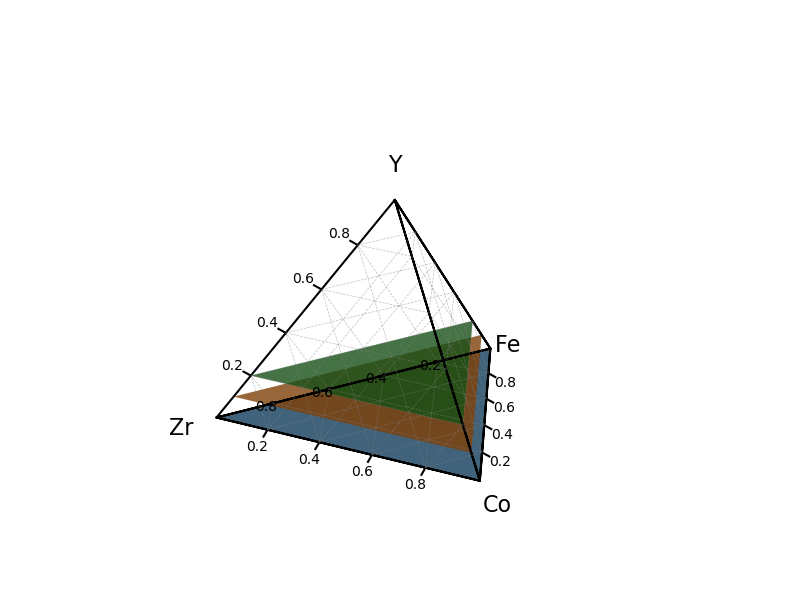

In [134]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111,projection='3d')
qf = QuaternaryAxes(ax=ax)
qf.draw_axes(color='k')
#expand_axeslims(qf.ax,1.1)
qf.label_corners(labels=['Zr','Co','Fe','Y'],offset=0.15,ha='center',va='center',size=16)



#qf.ax.plot_trisurf(x,y,z,antialiased=True,cmap=plt.cm.viridis,alpha=0.5)
qf.ax.axis('off')

qf.draw_normslice(slice_axis='Y',slice_start=0.,alpha=0.8)
qf.draw_normslice(slice_axis='Y',slice_start=0.1,alpha=0.8)
qf.draw_normslice(slice_axis='Y',slice_start=0.2,alpha=0.8)
#qf.gridlines()
qf.axes_ticks()
#qf.scatter(pts)


for face in ['f','l','r','b']:
    qf.face_gridlines(face,0.2,ls='--',lw=0.5,alpha=0.5)

In [76]:
nonzero_idx1 = np.where(np.sum(pts1,axis=0)!=0)
nonzero_idx2 = np.where(np.sum(pts2,axis=0)!=0)
common_idx = np.intersect1d(nonzero_idx1, nonzero_idx2)
pts1_srt = pts1[np.argsort(pts1[:,common_idx],axis=None),:]
pts2_srt = pts2[np.argsort(pts2[:,common_idx],axis=None),:]

gridline_pts = []
for p1, p2 in zip(pts1_srt,pts2_srt):
    gridline_pts.append(np.vstack((p1,p2)))
    
nonzero_idx3 = list(np.where(np.sum(pts3,axis=0)!=0)[0])
nonzero_idx1, nonzero_idx2, nonzero_idx3

((array([1, 3], dtype=int64),), (array([0, 1], dtype=int64),), [0, 3])

In [64]:
np.where(np.sum(pts1,axis=0)!=0)

(array([1, 3], dtype=int64),)

In [87]:
common_idx = np.intersect1d(nonzero_idx1, nonzero_idx2)

pts1[:,common_idx], pts2[:,common_idx]

(array([[0.1],
        [0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6],
        [0.7],
        [0.8],
        [0.9]]), array([[0.1],
        [0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6],
        [0.7],
        [0.8],
        [0.9]]))

In [91]:
pts1_srt = pts1[np.argsort(pts1[:,common_idx],axis=None),:]
pts2_srt = pts2[np.argsort(pts2[:,common_idx],axis=None),:]

gridline_pts = []
for p1, p2 in zip(pts1_srt,pts2_srt):
    gridline_pts.append(np.vstack((p1,p2)))

In [92]:
gridline_pts

[array([[0. , 0.1, 0. , 0.9],
        [0.9, 0.1, 0. , 0. ]]), array([[0. , 0.2, 0. , 0.8],
        [0.8, 0.2, 0. , 0. ]]), array([[0. , 0.3, 0. , 0.7],
        [0.7, 0.3, 0. , 0. ]]), array([[0. , 0.4, 0. , 0.6],
        [0.6, 0.4, 0. , 0. ]]), array([[0. , 0.5, 0. , 0.5],
        [0.5, 0.5, 0. , 0. ]]), array([[0. , 0.6, 0. , 0.4],
        [0.4, 0.6, 0. , 0. ]]), array([[0. , 0.7, 0. , 0.3],
        [0.3, 0.7, 0. , 0. ]]), array([[0. , 0.8, 0. , 0.2],
        [0.2, 0.8, 0. , 0. ]]), array([[0. , 0.9, 0. , 0.1],
        [0.1, 0.9, 0. , 0. ]])]

In [ ]:
x1 = np.arange(multiple,self.scale,multiple) #ascending order
x2 = self.scale - x1 #descending order
zeros = np.zeros(len(x1))
if axis=='l': #xa - ticks between C and A, keep xb=xd=0
    pts = np.column_stack((x1,zeros,x2,zeros))
elif axis=='r': #xb - ticks between A and B, keep xc=xd=0
    pts = np.column_stack((x2,x1,zeros,zeros))
elif axis=='b': #xc - ticks between B anc C, keep xa=xd=0
    pts = np.column_stack((zeros,x2,x1,zeros))
elif axis=='t': #xd - ticks between A and D, keep xb=xc=0
    pts = np.column_stack((x2,zeros,zeros,x1))

ps = np.sum(pts,axis=0)
nonzero_idx = list(np.where(ps!=0)[0])
zero_idx = list(np.where(ps==0)[0])

txt_pts = np.copy(pts)
dash_end = np.copy(pts)

#offset labels
txt_pts[:,nonzero_idx] = txt_pts[:,nonzero_idx] + offset
dash_end[:,nonzero_idx] = dash_end[:,nonzero_idx] + offset*(1-shrink)
txt_pts[:,zero_idx] = txt_pts[:,zero_idx] - offset
dash_end[:,zero_idx] = dash_end[:,zero_idx] - offset*(1-shrink)

In [8]:
x1 = np.arange(0.2,1,0.2) #ascending order
x2 = 1 - x1 #descending order
zeros = np.zeros(len(x1))
pts = np.column_stack((x1,zeros,x2,zeros))
t = np.sum(pts,axis=0)
list(np.where(t==0)[0])

[1, 3]

In [11]:
pts, t

(array([[0.2, 0. , 0.8, 0. ],
        [0.4, 0. , 0.6, 0. ],
        [0.6, 0. , 0.4, 0. ],
        [0.8, 0. , 0.2, 0. ]]), array([2., 0., 2., 0.]))

In [21]:
slice_start=0.1
axis_num=1 
plane_pts = np.zeros([4,4])
plane_pts[:,axis_num] = slice_start
for r in range(len(plane_pts)):
    plane_pts[r,r] = 1 - slice_start
plane_pts = np.delete(plane_pts,axis_num,axis=0)
plane_pts

array([[0.9, 0.1, 0. , 0. ],
       [0. , 0.1, 0.9, 0. ],
       [0. , 0.1, 0. , 0.9]])

In [154]:
import matplotlib.tri as mtri

<IPython.core.display.Javascript object>


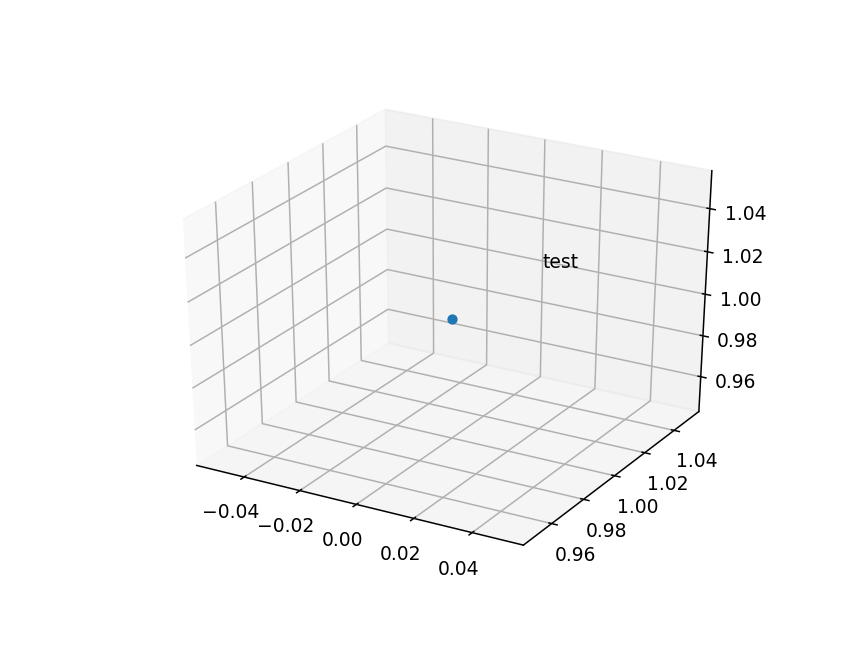

AttributeError: 'Figure' object has no attribute 'renderer'

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.scatter(0,1,1)

ax.text(x=0.02,y=1.02,z=1.02,s='test',withdash=True)
twd.set_position((0,1,1))
twd.draw(fig.renderer)

In [189]:
X


array([[0, 1, 1],
       [0, 1, 1],
       [0, 1, 1]])

In [190]:
Y

array([[0, 0, 0],
       [1, 1, 1],
       [0, 0, 0]])

In [192]:
tri.neighbors

array([[-1, -1,  1],
       [-1, -1,  0]], dtype=int32)

In [34]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

<IPython.core.display.Javascript object>


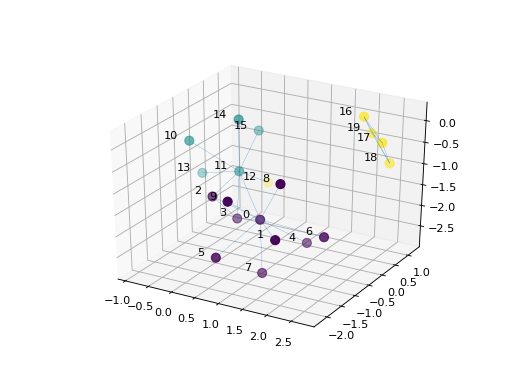

In [46]:
import matplotlib.pyplot as plt    
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# data: coordinates of nodes and links
xn = [1.1, 1.9, 0.1, 0.3, 1.6, 0.8, 2.3, 1.2, 1.7, 1.0, -0.7, 0.1, 0.1, -0.9, 0.1, -0.1, 2.1, 2.7, 2.6, 2.0]
yn = [-1.2, -2.0, -1.2, -0.7, -0.4, -2.2, -1.0, -1.3, -1.5, -2.1, -0.7, -0.3, 0.7, -0.0, -0.3, 0.7, 0.7, 0.3, 0.8, 1.2]
zn = [-1.6, -1.5, -1.3, -2.0, -2.4, -2.1, -1.8, -2.8, -0.5, -0.8, -0.4, -1.1, -1.8, -1.5, 0.1, -0.6, 0.2, -0.1, -0.8, -0.4]
group = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3]
edges = [(1, 0), (2, 0), (3, 0), (3, 2), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (11, 10), (11, 3), (11, 2), (11, 0), (12, 11), (13, 11), (14, 11), (15, 11), (17, 16), (18, 16), (18, 17), (19, 16), (19, 17), (19, 18)]
xyzn = np.column_stack((xn,yn,zn))#zip(xn, yn, zn)
segments = [(xyzn[s], xyzn[t]) for s, t in edges]                

# create figure        
fig = plt.figure(dpi=60)
ax = fig.gca(projection='3d')
#ax.set_axis_off()

# plot vertices
ax.scatter(xn,yn,zn, marker='o', c = group, s = 64)    
# plot edges
edge_col = Line3DCollection(segments, lw=0.2)
ax.add_collection3d(edge_col)
# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s=str(j), xyz=xyz_, fontsize=10, xytext=(-10,0),
               textcoords='offset points', ha='right',va='bottom')    
plt.show()

In [39]:
np.column_stack((xn,yn,zn))

array([[ 1.1, -1.2, -1.6],
       [ 1.9, -2. , -1.5],
       [ 0.1, -1.2, -1.3],
       [ 0.3, -0.7, -2. ],
       [ 1.6, -0.4, -2.4],
       [ 0.8, -2.2, -2.1],
       [ 2.3, -1. , -1.8],
       [ 1.2, -1.3, -2.8],
       [ 1.7, -1.5, -0.5],
       [ 1. , -2.1, -0.8],
       [-0.7, -0.7, -0.4],
       [ 0.1, -0.3, -1.1],
       [ 0.1,  0.7, -1.8],
       [-0.9, -0. , -1.5],
       [ 0.1, -0.3,  0.1],
       [-0.1,  0.7, -0.6],
       [ 2.1,  0.7,  0.2],
       [ 2.7,  0.3, -0.1],
       [ 2.6,  0.8, -0.8],
       [ 2. ,  1.2, -0.4]])